In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.optimize import minimize
import cmath

### Digital simulation

In [3]:
def rotate_right(l,n):
    return l[-n:]+l[:-n]

def individual_detection(spin_number, phonon_number, i):
    obserable_element = [(sigmaz()+qeye(2))/2]+[qeye(2) for j in np.arange(spin_number-1)]
    return tensor(rotate_right(obserable_element,i)+[qeye(phonon_number)])

def global_rotation(spin_number):
    spin_part = [(1+1j*sigmax())/np.sqrt(2) for i in np.arange(spin_number)]
    return tensor(spin_part)

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def H_LaserIon_pattern_multimodes(spin_number, laser_field, pattern, cut_off, eta, nu):
    spin_part = [sigmap()]+[qeye(2) for i in np.arange(spin_number-1)]
    motion_part = [create(cut_off)*destroy(cut_off)]+[qeye(cut_off) for i in np.arange(spin_number - 1)]
    H_inter = sum([tensor(rotate_right(spin_part,i)+[(-1j*eta*pattern[j][i]*(create(cut_off)+destroy(cut_off))).expm() for j in np.arange(spin_number)]) for i in np.arange(spin_number)])
    H_nu = sum([nu[i]*tensor([qeye(2) for i in np.arange(spin_number)]+rotate_right(motion_part,i)) for i in np.arange(spin_number)])
    H_inlist = [[H_inter, i[0]] for i in laser_field]
    H_inlistdag = [[H_inter.dag(), i[1]] for i in laser_field]
    H = [H_nu]+H_inlist+H_inlistdag
    return H

def spin_phonon_entanglement(state):
    eigen = np.abs(np.linalg.eig(state)[0])
    return -sum([value*np.log(value) for value in eigen])

In [4]:
def coefficient_single_P(t,arg):   
    return arg['amplitude_car']*cmath.exp(t*arg['detunning_car']*1j+arg['phaseCar']*1j)

def coefficient_single_N(t,arg):   
    return arg['amplitude_car']*cmath.exp(-t*arg['detunning_car']*1j-arg['phaseCar']*1j)

def Pulse_single_fre(amplitude_car, phase, duration):
     return [[[coefficient_single_N, coefficient_single_P]],{'amplitude_car': amplitude_car,\
        'detunning_car': 0, 'phaseCar': phase}, duration]
    
def coefficient_SDF_P(t,arg):   
    return arg['amplitude_BSB']*cmath.exp(t*arg['detunning_BSB']*1j+arg['phaseBSB']*1j)+arg['amplitude_RSB']*cmath.exp(t*arg['detunning_RSB']*1j+arg['phaseRSB']*1j)

def coefficient_SDF_N(t,arg):   
    return arg['amplitude_BSB']*cmath.exp(-t*arg['detunning_BSB']*1j-arg['phaseBSB']*1j)+arg['amplitude_RSB']*cmath.exp(-t*arg['detunning_RSB']*1j-arg['phaseRSB']*1j)

def Pulse_SDF(amplitude, detunning, phase, duration):
    return [[[coefficient_SDF_N, coefficient_SDF_P]],{'amplitude_BSB':amplitude, 'amplitude_RSB':amplitude, \
        'detunning_BSB':detunning, 'detunning_RSB': - detunning, \
        'phaseBSB':phase, 'phaseRSB':phase},duration]

def sequence_run(spin_number, pulses, psi0):
    states = []
    duration_start = 0
    total_tlist = []
    for pulse in control_pulses:
        laser_field = pulse[0]
        ARGS = pulse[1]
        duration = pulse[2]
        c_op_list = []
        tlist = np.linspace(duration_start, duration_start + duration, 10*int(duration+1))
        output1 = mesolve(H_LaserIon_pattern_multimodes(spin_number, laser_field, pattern, cut_off, eta, nu),\
                          psi0, tlist, c_op_list, [], args = ARGS, options=Options(store_states=True));
        states = states + [output1.states[i].ptrace(np.arange(spin_number)) for i in np.arange(len(output1.states))]
        psi0 = output1.states[-1]
        duration_start = duration_start + duration
        total_tlist = total_tlist + tlist.tolist()
    return [total_tlist, states]

### Test the performance

0.12566370614359174


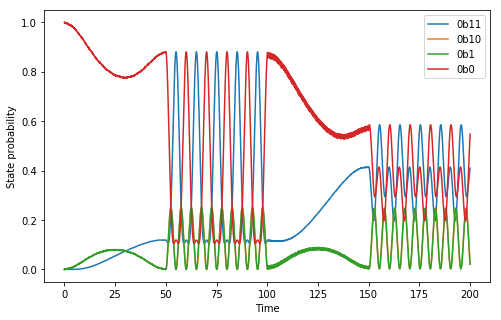

In [38]:
spin_number = 2
nu = [2.38*2*np.pi, 2.18*2*np.pi]
pattern = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
eta = 0.1

amplitude_SDF = np.pi/10
amplitude_car = np.pi/10
MS_delta = 2*eta*amplitude_BSB
print(MS_delta)

detunning_SDF = nu[0] + MS_delta
detunning_car = 0
phase = 0
cut_off = 7

control_pulses = [Pulse_SDF(amplitude_SDF, detunning_SDF, 0, 50),
                  Pulse_single_fre(amplitude_car, phase,50),
                  Pulse_SDF(amplitude_SDF, detunning_SDF, 0, 50),
                  Pulse_single_fre(amplitude_car, phase,50)]

psi0=tensor([basis(2,1) for i in np.arange(spin_number)] + [basis(cut_off,0) for i in np.arange(spin_number)])
output = sequence_run(spin_number, control_pulses, psi0)

total_tlist = output[0]
states = output[1]
fig, ax = plt.subplots(figsize=(8,5))
for i in np.arange(2**spin_number):
    ax.plot(output[0], [np.real(states[j][i,i]) for j in np.arange(len(states))], label = bin(2**spin_number - 1 - i))
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('State probability');

### Adiabatic evolv without phase-space optimization

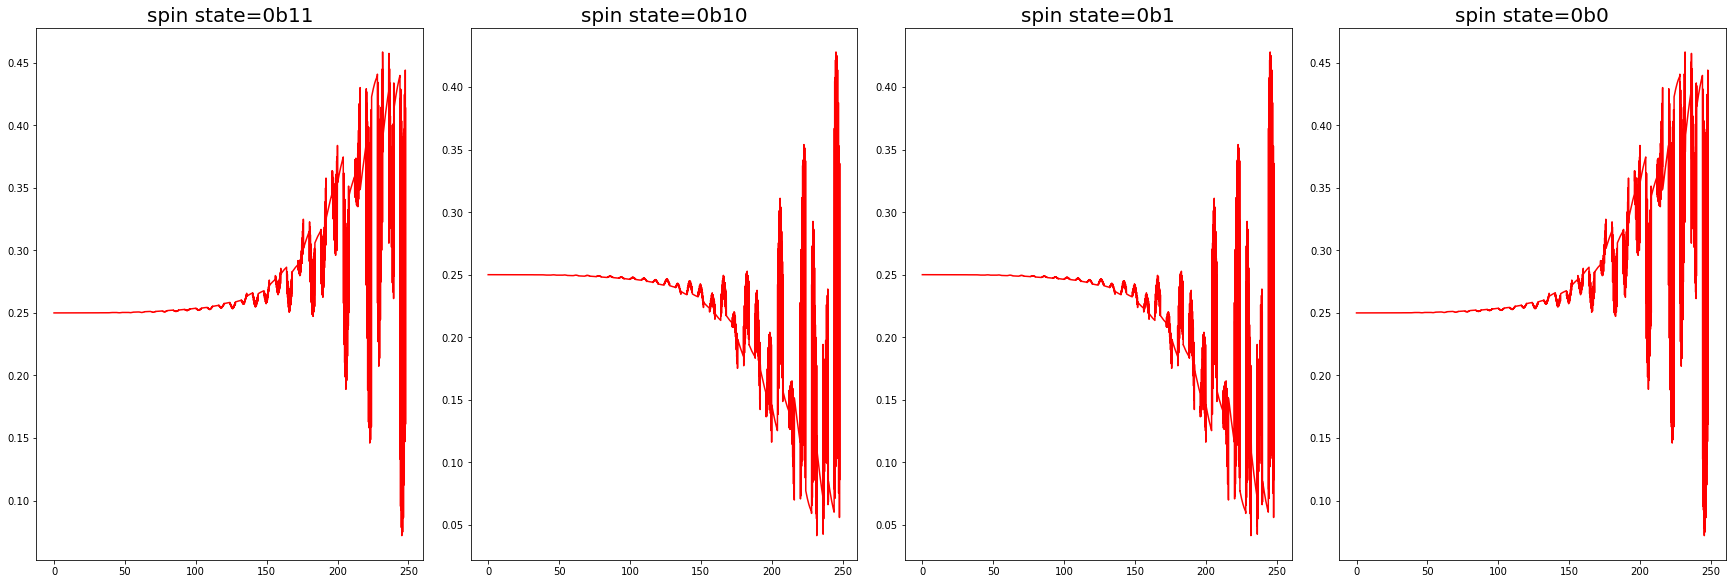

In [32]:
def SDF_profile(t):
    if(t<50):
        x = amplitude_linear*t/50
    else:
        x = amplitude_exp*(np.exp(t/38.45)-np.exp(50/38.45)+amplitude_linear/amplitude_exp)
    return x

spin_number = 2
nu = [3.7*2*np.pi, 3.5*2*np.pi]
pattern = np.array([[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1/np.sqrt(2)]])
eta = 0.1
cut_off = 7

scale = 39.46153846153846
amplitude_car = 0.7*np.pi/118
amplitude_linear = np.pi/11.25
amplitude_exp = np.pi/20

detunning_SDF = nu[0] - 0.25*2*np.pi
phase_car = np.pi
phase_SDF = 0

SDF_step = 1/0.25
car_step = 1/0.25
total_duration = 250

control_pulses = np.array([[Pulse_single_fre(amplitude_car, phase_car, car_step),\
                            Pulse_SDF(SDF_profile(i*SDF_step), detunning_SDF, phase_SDF, SDF_step),
                  ] for i in np.arange(total_duration//(SDF_step+car_step))])

control_pulses = np.reshape(control_pulses,(2*int(total_duration//(SDF_step+car_step)),3)).tolist()


psi0=tensor([(basis(2,1)-basis(2,0))/np.sqrt(2) for i in np.arange(spin_number)] + [basis(cut_off,0) for i in np.arange(spin_number)])
output = sequence_run(spin_number, control_pulses, psi0)


total_tlist = output[0]
states = output[1]
figsize = (24, 8)
cols = 4
rows = 2**spin_number//4
fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, 2**spin_number)
for ax, i in zip(axs, np.arange(2**spin_number)):
    ax.set_title('spin state=%s' %  bin(2**spin_number - 1 - i), fontsize=20)
    ax.plot(total_tlist, [np.real(states[j][i,i]) for j in np.arange(len(states))], 'r')

/Users/mu_qiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/mu_qiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


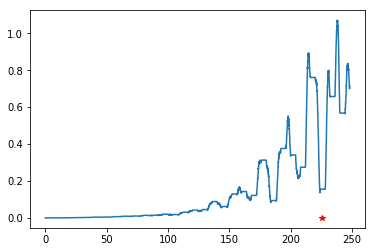

In [33]:
plt.plot(total_tlist, [spin_phonon_entanglement(state) for state in states], [229.846], [0], 'r')
plt.plot([total_tlist[-280]], [0], 'r', marker='*')
plt.show()

In [34]:
print(total_tlist[-280])
states[-280]

225.6326530612245


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.43133677+6.33178180e-18j -0.15321472+6.03333782e-02j
  -0.15321472+6.03333782e-02j  0.40721239+5.44076907e-16j]
 [-0.15321472-6.03333782e-02j  0.06866323-1.09574121e-18j
   0.06851427-8.78166896e-17j -0.15321472-6.03333782e-02j]
 [-0.15321472-6.03333782e-02j  0.06851427+8.70113969e-17j
   0.06866323-1.41368696e-19j -0.15321472-6.03333782e-02j]
 [ 0.40721239-5.32925610e-16j -0.15321472+6.03333782e-02j
  -0.15321472+6.03333782e-02j  0.43133677+4.69471243e-18j]]

### With trajectory optimization

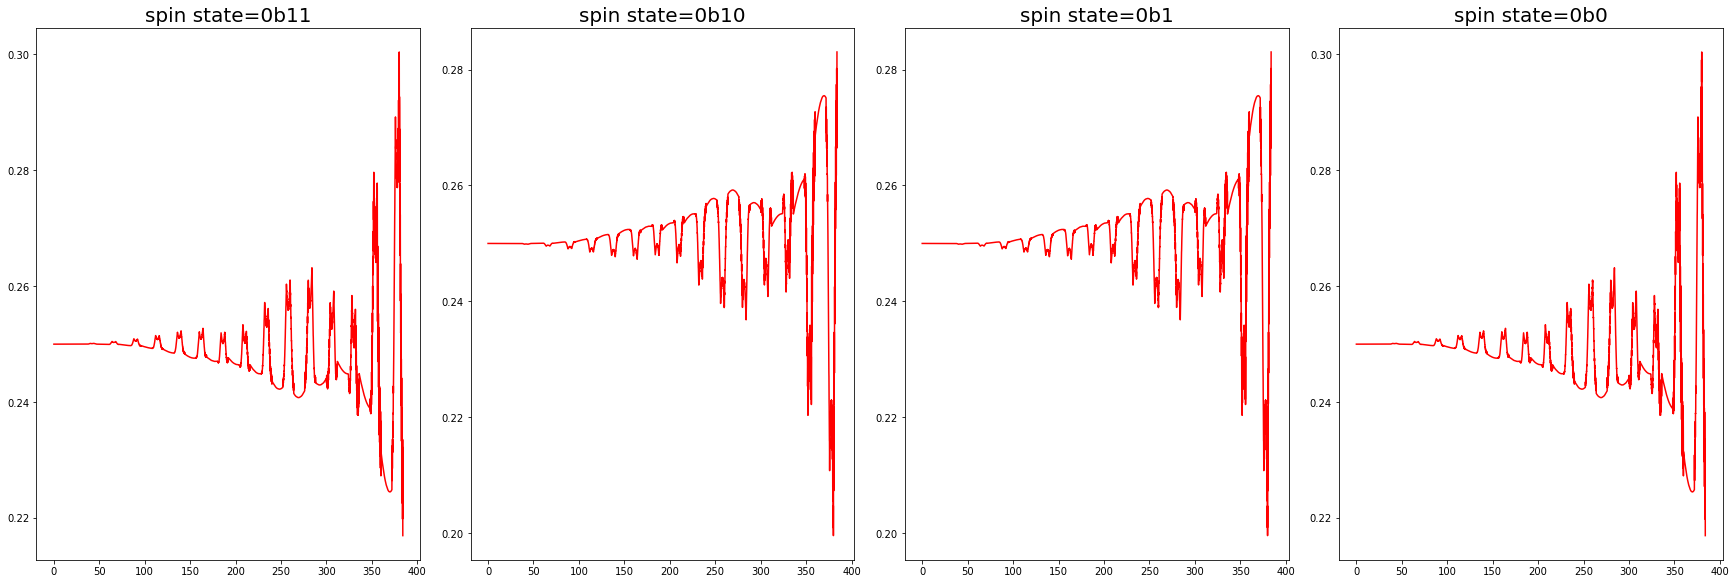

In [17]:
def SDF_profile(t):
    if(t<50):
        x = amplitude_linear*t/50
    else:
        x = amplitude_exp*(np.exp(t/38.45)-np.exp(50/38.45)+amplitude_linear/amplitude_exp)
    return x

spin_number = 2
nu = [3.7*2*np.pi, 3.5*2*np.pi]
pattern = np.array([[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1/np.sqrt(2)]])
eta = 0.1
cut_off = 7

scale = 39.46153846153846
amplitude_car = 0.7*np.pi/118
amplitude_linear = np.pi/11.25
amplitude_exp = np.pi/20

detunning_SDF = nu[0] - 0.25*2*np.pi
phase_car = np.pi
phase_SDF = 0

SDF_step = 1/0.25
car_step = 3/0.25
total_duration = 400

overall_amp = 3

control_pulses = np.array([[Pulse_single_fre(amplitude_car, phase_car, car_step),\
                            Pulse_SDF(overall_amp*0.6479361632942985*SDF_profile(i*SDF_step), detunning_SDF, phase_SDF, SDF_step),
                            Pulse_SDF(-overall_amp*0.4004465714560788*SDF_profile(i*SDF_step), detunning_SDF, phase_SDF, SDF_step),
                            Pulse_SDF(overall_amp*0.6479361632942985*SDF_profile(i*SDF_step), detunning_SDF, phase_SDF, SDF_step)
                           ] for i in np.arange(total_duration//(3*SDF_step+car_step))])

control_pulses = np.reshape(control_pulses,(4*int(total_duration//(3*SDF_step+car_step)),3)).tolist() # change to laser pulse without sublist


psi0=tensor([(basis(2,1)-basis(2,0))/np.sqrt(2) for i in np.arange(spin_number)] + [basis(cut_off,0) for i in np.arange(spin_number)])
output = sequence_run(spin_number, control_pulses, psi0)


total_tlist = output[0]
states = output[1]
figsize = (24, 8)
cols = 4
rows = 2**spin_number//4
fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, 2**spin_number)
for ax, i in zip(axs, np.arange(2**spin_number)):
    ax.set_title('spin state=%s' %  bin(2**spin_number - 1 - i), fontsize=20)
    ax.plot(total_tlist, [np.real(states[j][i,i]) for j in np.arange(len(states))], 'r')

/Users/mu_qiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/mu_qiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


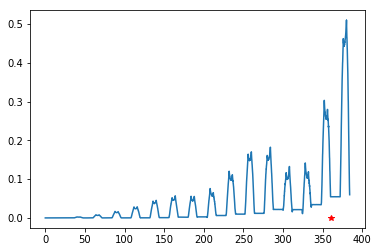

In [18]:
plt.plot(total_tlist, [spin_phonon_entanglement(state) for state in states], [229.846], [0], 'r')
plt.plot([total_tlist[-280]], [0], 'r', marker='*')
plt.show()

/Users/mu_qiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/mu_qiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


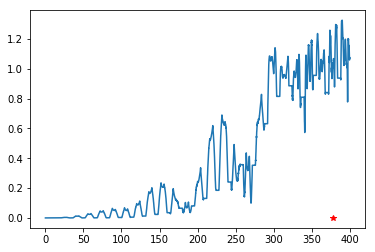

In [12]:
plt.plot(total_tlist, [spin_phonon_entanglement(state) for state in states], [229.846], [0], 'r')
plt.plot([total_tlist[-280]], [0], 'r', marker='*')
plt.show()

In [ ]:
[Omega1,Omega2,Omega3]=[0.2,0.1,0.3]*Omega